# Intraoperative Functional Thermography 
## univariate Bayesian U-Net

In [1]:
import tensorflow as tf
import sep_unet
import matplotlib.pyplot as plt
import numpy as np
import h5py
import time
import SelectiveDropout

c:\users\user\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Bayesian U-Net

In [ ]:
pData = 'snklb_Raw_muSigmaVariation.mat'
pModel = None
lr = 1e-3
noEpochs = 100
noFeatures = 32
depth = 3
activation = "leakyReLU" # ELU, sigmoid
pTrainedModel = str(activation) + "_" + str(depth) + "_" + str(noFeatures) + "_" + str(lr) + "_" + str(noEpochs)

In [ ]:
unet = sep_unet.fit(pData=pData, depth=depth,epochs=noEpochs,model=pModel,lr=lr,noFeatures=noFeatures)

*** PROCESSING snklb_Raw_muSigmaVariation.mat with new U-Net compression architecture
*** U-Net Depth: 3 Features 32
*** Checkpointing model to sep_unet_doInTraining_sigmoid_avPool2_d3_f32_lr0.001_{epoch:02d}-{val_loss:.6f}.h5
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024, 1)      0                                            
__________________________________________________________________________________________________
average_pooling1d_1 (AveragePoo (None, 128, 1)       0           input_1[0][0]                    
_________________________________________________

In [21]:
unet.save(pTrainedModel)

## Analyse io data

In [22]:
pioData = 'Brud.mat'
f = h5py.File(pioData, "r")
samples = np.swapaxes(np.array(f["Bsamples"].value),0,1)
f.close()
samples = sep_unet.normalizeData(samples)
samples = samples[..., np.newaxis]

In [24]:
start_time = time.time()
with tf.device('/gpu:0'):
  samples_pred = unet.predict(samples)
elapsed_time = time.time() - start_time
print('elapsed (GPU): ' + str(elapsed_time) + ' s')

elapsed (GPU): 641.3335998058319 s


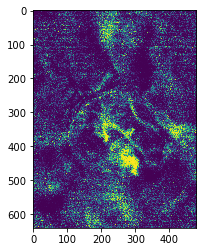

In [26]:
plt.imshow(np.reshape(samples_pred[1],[640, 480]))
plt.show()

In [29]:
pResult = 'res_' + pTrainedModel + pioData
with h5py.File(pResult,"w") as f:
#  d1 = f.create_dataset('samples',data=samples)
  d2 = f.create_dataset('a',data=samples_pred[1])


# Predict uncertainty

In [9]:
f = h5py.File(pioData, "r")
samples = np.swapaxes(np.array(f["Bsamples"].value),0,1)
f.close()
samples = sep_unet.normalizeData(samples)
samples = samples[..., np.newaxis]

In [10]:
f = h5py.File(pData, "r")
samples = np.array(f["Bsamples"].value)
f.close()
samples = sep_unet.normalizeData(samples)
samples = samples[..., np.newaxis]

In [11]:
def activateAllDropoutLayers(m):
    ll = [item for item in m.layers if type(item) is SelectiveDropout]
    for ditLayer in ll:
        ditLayer.setDropoutEnabled(1)

In [12]:
def predict_with_uncertainty(model, x, n_iter=10):
    activateAllDropoutLayers(model)
    result = np.zeros((n_iter, x.shape[0]))

    for iter in range(n_iter):
        result[iter,] = np.squeeze(model.predict(x)[1])

    prediction = result.mean(axis=0)
    uncertainty = result.var(axis=0)
    return prediction, uncertainty, result

In [13]:
prediction, uncertainty, result = predict_with_uncertainty(unet,samples[0:15,:,:],n_iter=50)

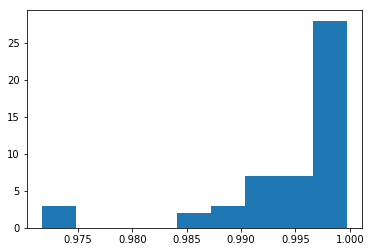

In [14]:
#plt.plot(result[:,5])
#plt.show()
s = result[:,5]
plt.hist(s, bins='auto')
plt.show()

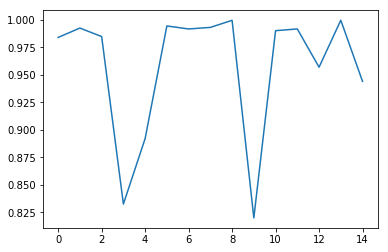

In [15]:
plt.plot(prediction)
plt.show()

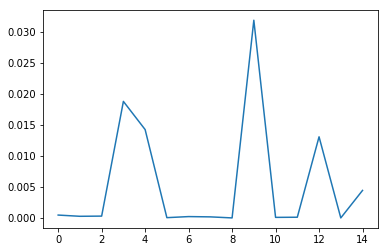

In [16]:
plt.plot(uncertainty)
plt.show()

## No Signal

In [17]:
prediction, uncertainty, result = predict_with_uncertainty(unet,samples[-15:-1,:,:],n_iter=50)

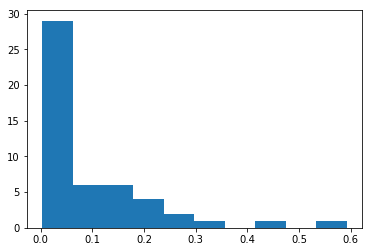

In [18]:
s = result[:,5]
plt.hist(s, bins='auto')
plt.show()

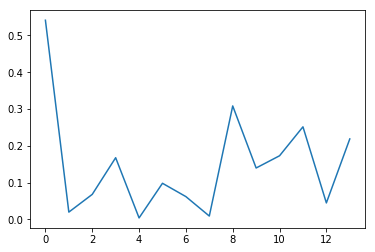

In [19]:
plt.plot(prediction)
plt.show()

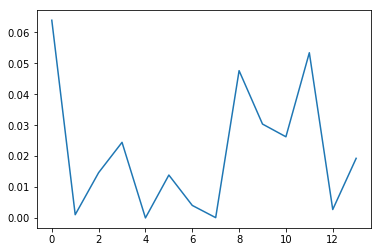

In [20]:
plt.plot(uncertainty)
plt.show()